***Instituto Tecnológico de Costa Rica (ITCR)***

**Sede Interuniversitaria de Alajuela**

**Escuela de Computación**

**Profesora: María Auxiliadora Mora**

**Curso: Inteligencia Artificial**
    
**Estudiantes: María José Barquero - Te Chen**

# Sección 2. Análisis de sentimientos con redes neuronales recurrentes LSTM utilizando Pytorch.

El conjunto de datos que se va a utilizar para este ejemplo es "Trip advisor reviews sentiment analysis" con el objetivo de predecir si el comentario de un usuario estará dentro del rango 1 a 5. Este conjunto de datos solo tienen dos atributos que son review y rating. (Link:https://www.kaggle.com/code/wiktorbrk/trip-advisor-reviews-sentiment-analysis/data)

In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from collections import Counter
import string
import re
import sklearn
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
is_cuda = torch.cuda.is_available()
device = torch.device("cpu")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Leer los datos
csv = '/content/tripadvisor_hotel_reviews.csv'
df = pd.read_csv(csv)

df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [4]:
#Mostrar los primeros 5
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
# Eliminar los datos nulos
df = df.dropna(how='any',axis=0) 
df.dropna(how = 'all')
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [6]:
#Cantidad de valor que hay por ranting
print(df.Rating.value_counts())

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64


In [7]:
#Balancear los datos ya que la cantidad que hay de rating 5 es como 5 veces que de rating 1
df2 = df.groupby('Rating')
df2 = df2.apply(lambda x: x.sample(df2.size().min()).reset_index(drop=True))

In [8]:
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [9]:
#Función: process_string
#Dominio: string
#Codominio: string
#Esta función se encarga de procesar el string 
def preprocess_string(string):
    # Remove all non-word characters (everything except numbers and letters)
    string = re.sub(r"[^\w\s]", '', string)
    # Replace all runs of whitespaces with no space
    string = re.sub(r"\s+", '', string)
    # replace digits with no space
    string = re.sub(r"\d", '', string)

    return string

#Función: tockenize
#Dominio: recibe los datos seperados de trainings y de prueba
#Codominio: string
#Esta función se encarga de procesar el string 
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_val),onehot_dict

#Función: padding
#Dominio: recibe oraciones y largo de secuencia
#Codominio:list
#Esta función se encarga de agregar padding 
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


#Función: accurac
#Dominio: recibe prediccion y etiqueta original
#Codominio: numero natural 
#Esta función se encarga de calcular accuracy
def accurac(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [10]:
#Tockeanizar los valores
x = df2['Review'].values
y = df2['Rating'].values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.1)
x_test_n = x_test #Datos que se va a utilizar luego para hacer las pruebas
y_test_n = y_test
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
# Oraciones a vectores en R300
x_train_pad = padding(x_train,300)
x_test_pad = padding(x_test,300)
x_test_pad.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(711, 300)

In [11]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [12]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        #capas de incrustación y LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        #eliminar capas
        self.dropout = nn.Dropout(0.3)
    
        # Capa linear y sigmoid 
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function and reshape to be batch_size first
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Crear dos nuevos tensores con tamaños n_layers x batch_size x hidden_dim,
        # inicializado a cero, para el estado oculto y el estado de la célula de LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [13]:
#Definir los hiperparametros
no_layers = 2
embedding_dim = 64
output_dim = 1
hidden_dim = 256
vocab_size = len(vocab) + 1 #más 1 extra de padding
#Ajustar modelo
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [14]:
# loss and optimization functions
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
clip = 5
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

In [15]:
epochs = 3
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)   
        # Crear nuevas variables para el estado oculto, de lo contrario
        # pasaríamos por todo el historial de entrenamiento
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        #Calcular la perdida y accuracy
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = accurac(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = accurac(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        #torch.save(model.review(), 'review.pt')
        print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print('-------------------------------------------------------')

Epoch 1
train_loss : -140.5191416263463 val_loss : -203.14285714285714
train_accuracy : 19.987488270253362 val_accuracy : 18.846694796061886
Validation loss decreased (inf --> -203.142857).  Saving model ...
-------------------------------------------------------
Epoch 2
train_loss : -199.35433070866142 val_loss : -203.0
train_accuracy : 19.987488270253362 val_accuracy : 18.9873417721519
-------------------------------------------------------
Epoch 3
train_loss : -199.54330708661416 val_loss : -202.42857142857142
train_accuracy : 20.00312793243666 val_accuracy : 18.9873417721519
-------------------------------------------------------


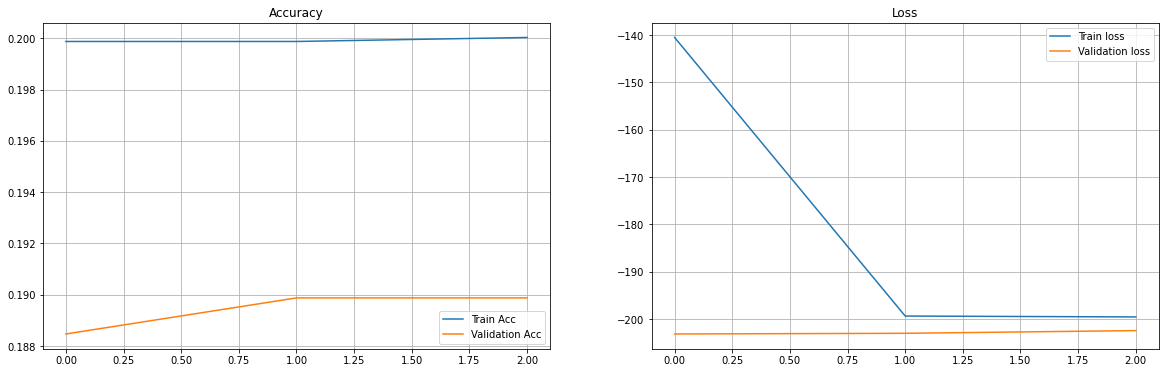

In [16]:
#Gráfica de accuracy
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
#Gráfica de pèrdida
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [27]:
#Función: predict_text
#Dominio: recibe el texto
#Codominio: numero natural 
#Esta función predecir un texto y en este caso el review
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding(word_seq,300))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        ans, h = model(inputs, h)
        return(ans.item())

#Función: calculate
#Dominio: recibe el texto
#Codominio: numero natural 
#Esta función llama a la función de predecir texto
def calculate(text):
    prob = predict_text(text)
    rating = int((prob * 10) // 2)
    return rating

### Algunos ejemplos de pruebas

In [18]:
index = 5
print(df['Review'][index])
print('-------------------------------------------------------')
print(f'Actual rating is: {df["Rating"][index]}')
print('-------------------------------------------------------')
pro = predict_text(df['Review'][index])
status = int((pro * 10) // 2)
print(f'predicted rating is {status}')

love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husband celebrating 12th wedding anniversary, talk mixed emotions, booked suite hotel monte carlos, loaned beautiful fan-tanned goldfish named joliet weekend visited dogs worked desk human companions, room decorated nicely couch used pillows, l'occitane bath amenities welcome sight, room quiet peaceful, wireless internet access wonderful server went morning leaving problems printing boarding passes, afternoon reception serves oenophile-satisfying wine australia scrumptious cookies, restaurant closed renovation stay finally ate food good drinks better, word caution restaurant larger person not sit booths wo n't fit, 5'6 125 lbs husband 5'9 175. table smack-against stomach couple inches space mighty uncomfortable patron larger pregnant, bad design opinion place decorated funky welcoming way metal wood handblown glass light fixtures expect seattle capital glass art industry, definitely stay reason,

In [19]:
index = 12
print(df['Review'][index])
print('-------------------------------------------------------')
print(f'Actual rating is: {df["Rating"][index]}')
print('-------------------------------------------------------')
pro = predict_text(df['Review'][index])
status = int((pro * 10) // 2)
print(f'predicted rating is {status}')

nice hotel good location hotel kimpton design whimsical vibe fun, staff young casual problem hotel busy stay friendly helpful, group reserved rooms gave connecting rooms fuss, not busy week.the rooms decent size not huge pretty average city hotel, beds nice bathrooms clean bright pocket doors ideal busy bathroom, room design bright cheery flat panel tv, location little noisy fine 5th floor, location convenient walkable attractions new central library sam art museum benaroya concert hall pike place market, parking steep 29/night, evening wine receptions popular,  
-------------------------------------------------------
Actual rating is: 4
-------------------------------------------------------
predicted rating is 5


In [20]:
index = 14
print(df['Review'][index])
print('-------------------------------------------------------')
print(f'Actual rating is: {df["Rating"][index]}')
print('-------------------------------------------------------')
pro = predict_text(df['Review'][index])
status = int((pro * 10) // 2)
print(f'predicted rating is {status}')

great hotel night quick business trip, loved little touches like goldfish leopard print robe, complaint wifi complimentary not internet access business center, great location library service fabulous,  
-------------------------------------------------------
Actual rating is: 4
-------------------------------------------------------
predicted rating is 5


### Resultados

In [36]:
#Pasar a listas
x_test_list = list(x_test_n)
y_test_list = list(y_test_n)
actual = y_test_list
#Calcular las predicciones
predict = map(calculate,x_test_list)
predict = list(predict)

In [37]:
#f1_score
f1_score(actual, predict,average=None)

array([0.        , 0.        , 0.        , 0.        , 0.33098592])

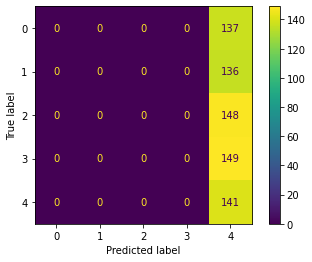

In [38]:
#confusion_matrix
cm = confusion_matrix(actual, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [39]:
#accuracy
accuracy = sklearn.metrics.accuracy_score(np.array(actual),np.array(predict))
print(accuracy)

0.19831223628691982


In [42]:
#Precision
precision_score(np.array(actual),np.array(predict),average=None)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.        , 0.        , 0.        , 0.19831224])

### Análisis de resultados

- Los resultados obtenidos estuvieron muy malos, creemos que la causa es porque no hizo  un buen preprocesamiento de datos y el modelo no cuenta con los hiperparámetros más adecuados para el entrenamiento. A lo largo de este proyecto, estuvimos probando diferentes hiperparámetros, y el que más afecta el número de época, ya que si el número de época es un valor grande posiblemente el resultado sea mejor, ya que el modelo se va a ir mejorando a través de diferentes capas.
- Otro problema que tenemos es que se presentan muchos ceros en la matriz de confusión, esto fue causado por las conversiones de los tipos de datos y al tirar warning, el programa se asume que es cero. Pero cuando hicimos las pruebas si nos tiraba diferente ratings.

### Posibles mejoras
- Creemos que si aumentamos la cantidad de épocas de entrenamiento puede mejorar el resultado, pero se debe mantener un balance, ya que a la hora de subir más épocas muy posiblemente su dura más construyendo el modelo.  A través de las pruebas que se hicieron nos dimos cuenta de que mientras más grande sea la cantidad de épocas el resultado es mejor, es decir mayor exactitud del modelo. 
- El otro factor muy importante es encontrar los hiperparámetros más adecuados, para esto se debe realizar diferentes pruebas, y nos dimos cuenta mientras más capas entrenen el modelo y el resultado se ve mejor. 
- Se debe hacer un buen preprocesamiento de datos antes de entrenar el modelo, en el caso de este ejemplo que usamos textos es importante saber el largo de cada review, ya que a veces con muy pocas palabras y el rating puede ser muy ambiguo, y vimos un resultado mejor cuando eliminamos aquellos reviews que tienen menos de 10 palabras.

### Conclusiones
- Los resultados obtenidos del modelo no son tan bueno como esperábamos, pero creemos que esto puede ser debido a que hay palabras que se pueden interpretar de diferentes maneras y esto llega afectar el análisis de sentimiento.
- Nos dimos cuenta de que los resultados fueron afectados debido inadecuada limpieza y procesamiento de datos, ya que después de eliminar los reviews que son de menos de 10 palabras, el resultado mejoró. 
- Al aumentar el número de épocas puede mejorar un poco el resultado, ya que en cada época el modelo se va mejorando. iva.
- Consideramos que es un ejercicio muy interesante, debido a que pudimos aplicar procesamiento de lenguaje, al mismo tiempo entender mejor como es que funciona el análisis de sentimiento y entender mejor los otros temas vistos en la clase. 
- Llegamos a concluir mientras más datos utilicemos para el entrenamiento el modelo mejorará, ya que al inicio utilizábamos muy pocos datos para entrenar debido a que si no nos iba a durar una gran cantidad de tiempo para poder ver un resultado.

### Referencias
- Curso de Inteligencia Artificial: Semana 10, Semana 11, Semana 12 y Semana 13. Curso impartido y diseñado por la profesora María Auxiliadora Mora Cross
- Thushan Ganegedara. (2019, 31 de diciembre). Predictions with LSTM in Python.  https://www.datacamp.com/tutorial/lstm-python-stock-market
- GitHub. (2019, 23 de april). cnn-lstm-bilstm-deepcnn-clstm-in-pytorch. https://github.com/bamtercelboo/cnn-lstm-bilstm-deepcnn-clstm-in-pytorch